In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import shap
import pickle
import cloudpickle
import numpy as np
import scipy as sp
import pandas as pd
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order, plot_2d, \
                       plot_feature_importance_bar, plot_feature_importance_scatter, plot_feature_effects, plot_forces, \
                       merge_explanations, plot_decision, perform_hierarchical_clustering, \
                       plot_dendrogram, extract_clustering, get_class_occurences_in_clusters 
from diro2c_wrapper import generate_diro2c_explanation, plot_diro2c_2d, plot_diro2c_tree
shap.initjs()
%matplotlib inline

# Setup Task

In [2]:
X_train1, y = make_classification(n_samples=300, n_features=3, n_redundant=0, n_informative=2,
                           n_clusters_per_class=1, class_sep=0.75, random_state=0)
X_train1 *= 100
feature_names = np.array(['x1', 'x2', 'x3'])
idx_x, idx_y = 1, 2

In [3]:
X = X_train1.copy()
X[:, 0] = X[:, 1]

In [4]:
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression()
lm.fit(X_train1, y)
lm.intercept_, lm.coef_

(array([1.11353567]), array([[ 0.00049831, -0.02215288,  0.0307764 ]]))

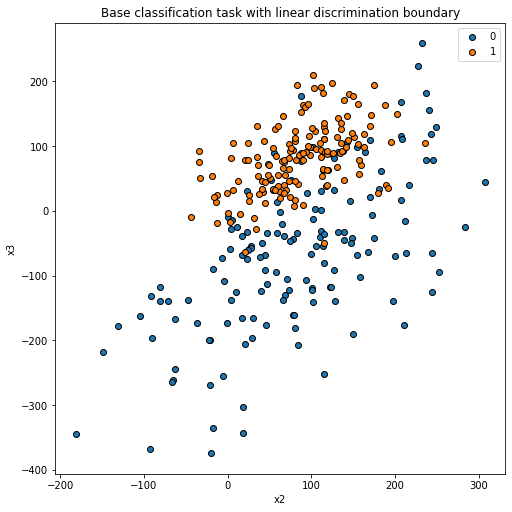

In [5]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
plot_decision_boundary(X, y, 'Base classification task with linear discrimination boundary', feature_names,
                       predict=lm.predict, class_names=lm.classes_, idx_x=idx_x, idx_y=idx_y,
                       fig=fig, ax=ax)

In [6]:
clf_a = lm

In [7]:
clf_b = LogisticRegression()
X_train2 = X_train1.copy()
X_train2[:, 0] = X_train1[:, 1]
X_train2[:, 1] = X_train1[:, 0]
clf_b.fit(X_train2, y)
clf_b.intercept_, lm.coef_

(array([1.11353567]), array([[ 0.00049831, -0.02215288,  0.0307764 ]]))

In [8]:
comparer = ModelComparer(clf_a, clf_b, feature_names)
comparer.fit(X, y)

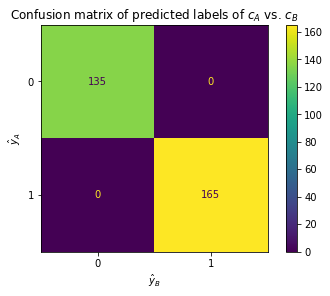

In [9]:
comparer.plot_confusion_matrix(X)

TODO: contours are wrong

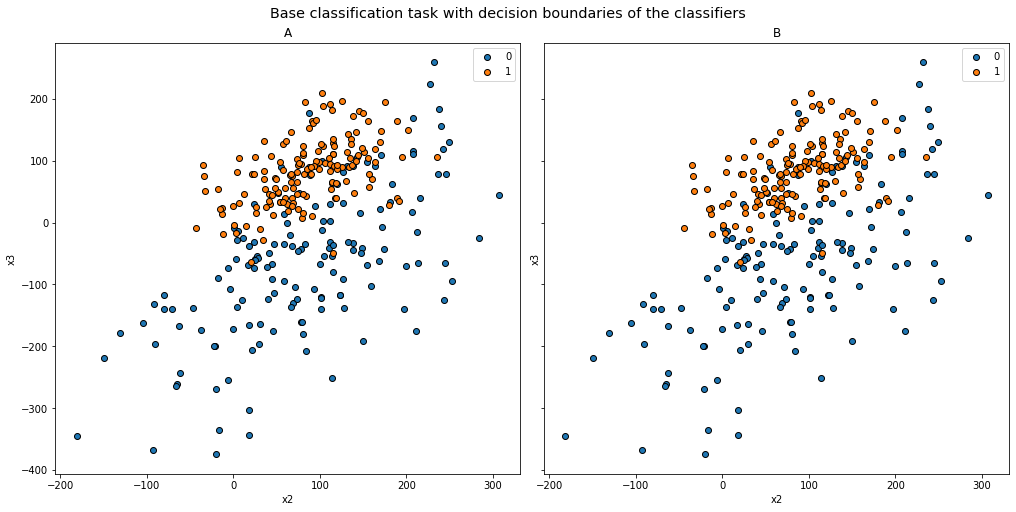

In [10]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='label', idx_x=idx_x, idx_y=idx_y)

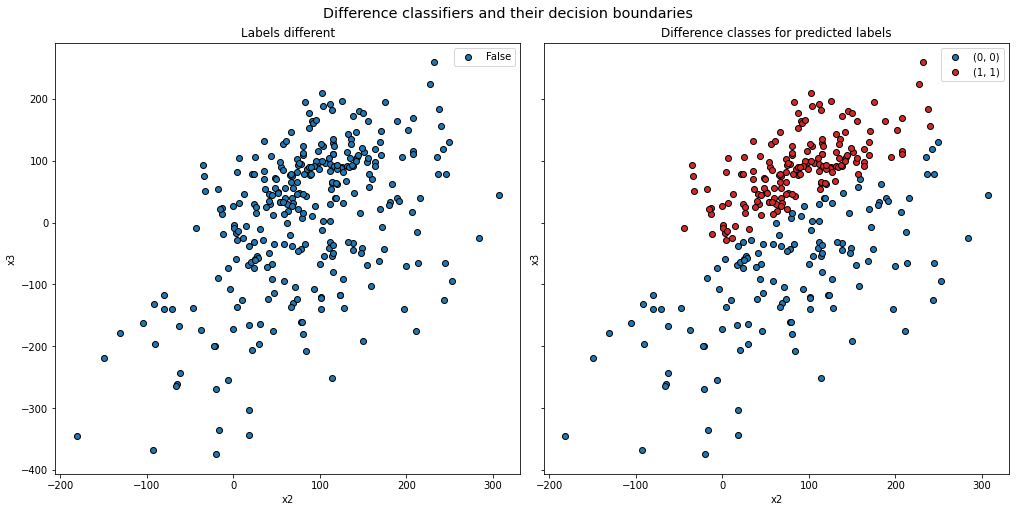

In [11]:
comparer.plot_decision_boundaries(X, idx_x=idx_x, idx_y=idx_y)

# Explain using Interpretability Methods

In [12]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['labels'])

CPU times: user 6.86 s, sys: 194 ms, total: 7.05 s
Wall time: 8.37 s


In [13]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
mclass_diff = comparer.predict_mclass_diff(explanations.data)

# Global Explanations

## Traditional Approach

### Feature importance

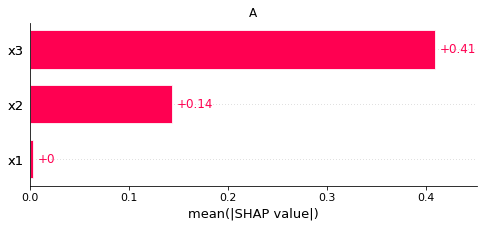

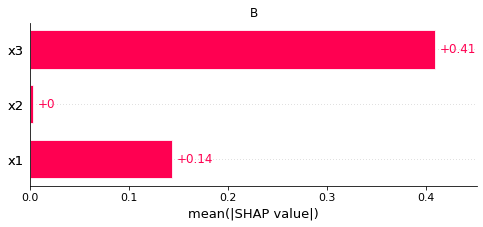

In [14]:
feature_order, _ = calc_feature_order(explanations.indiv.labels[:, :, 1])
plot_feature_importance_bar(explanations.indiv.labels.A[:, :, 1], title='A', feature_order=feature_order)
plot_feature_importance_bar(explanations.indiv.labels.B[:, :, 1], title='B', feature_order=feature_order)

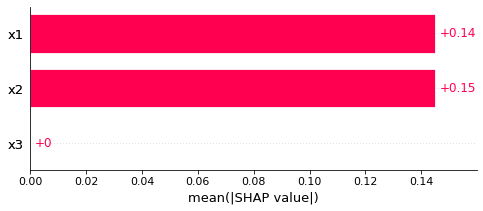

In [15]:
plot_feature_importance_bar(explanations.indiv_diff.labels[:, :, 1])

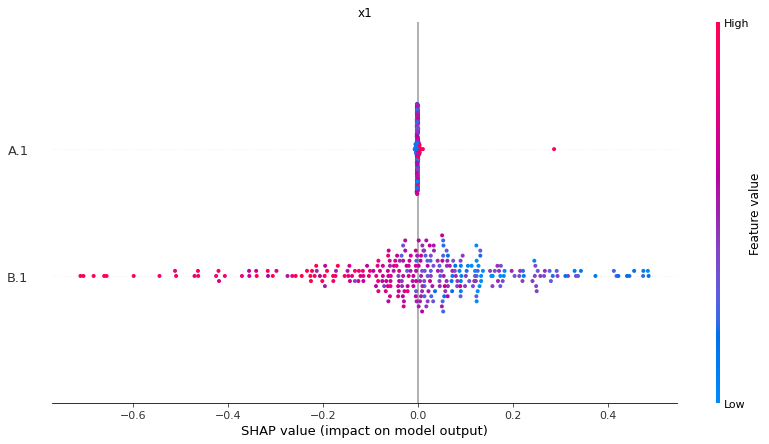

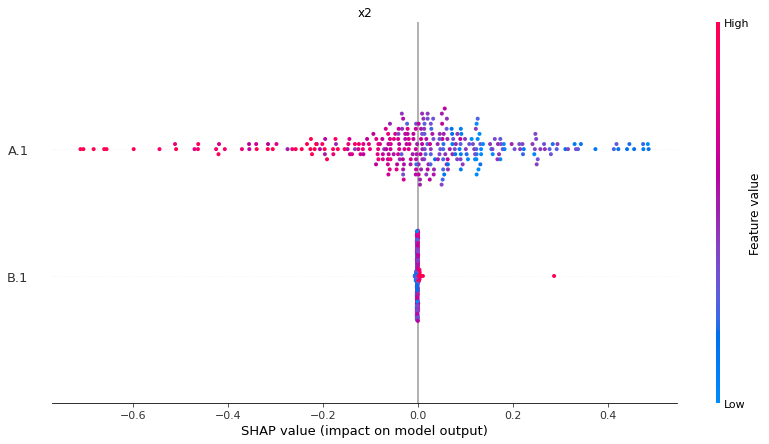

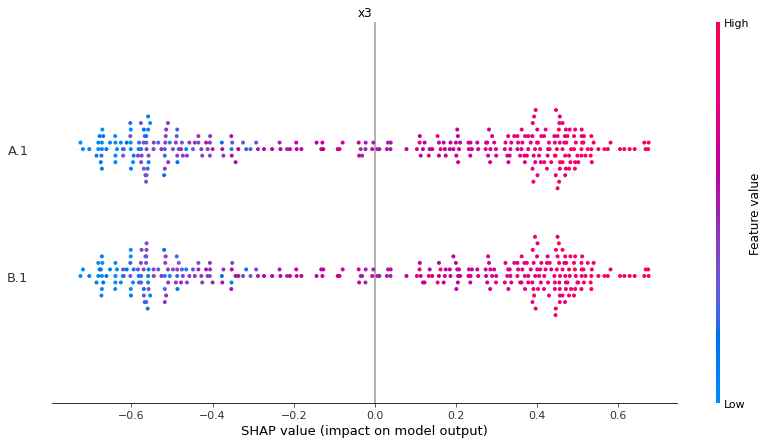

In [16]:
plot_feature_importance_scatter(explanations.indiv.labels[:, :, 1])

### Feature Effects

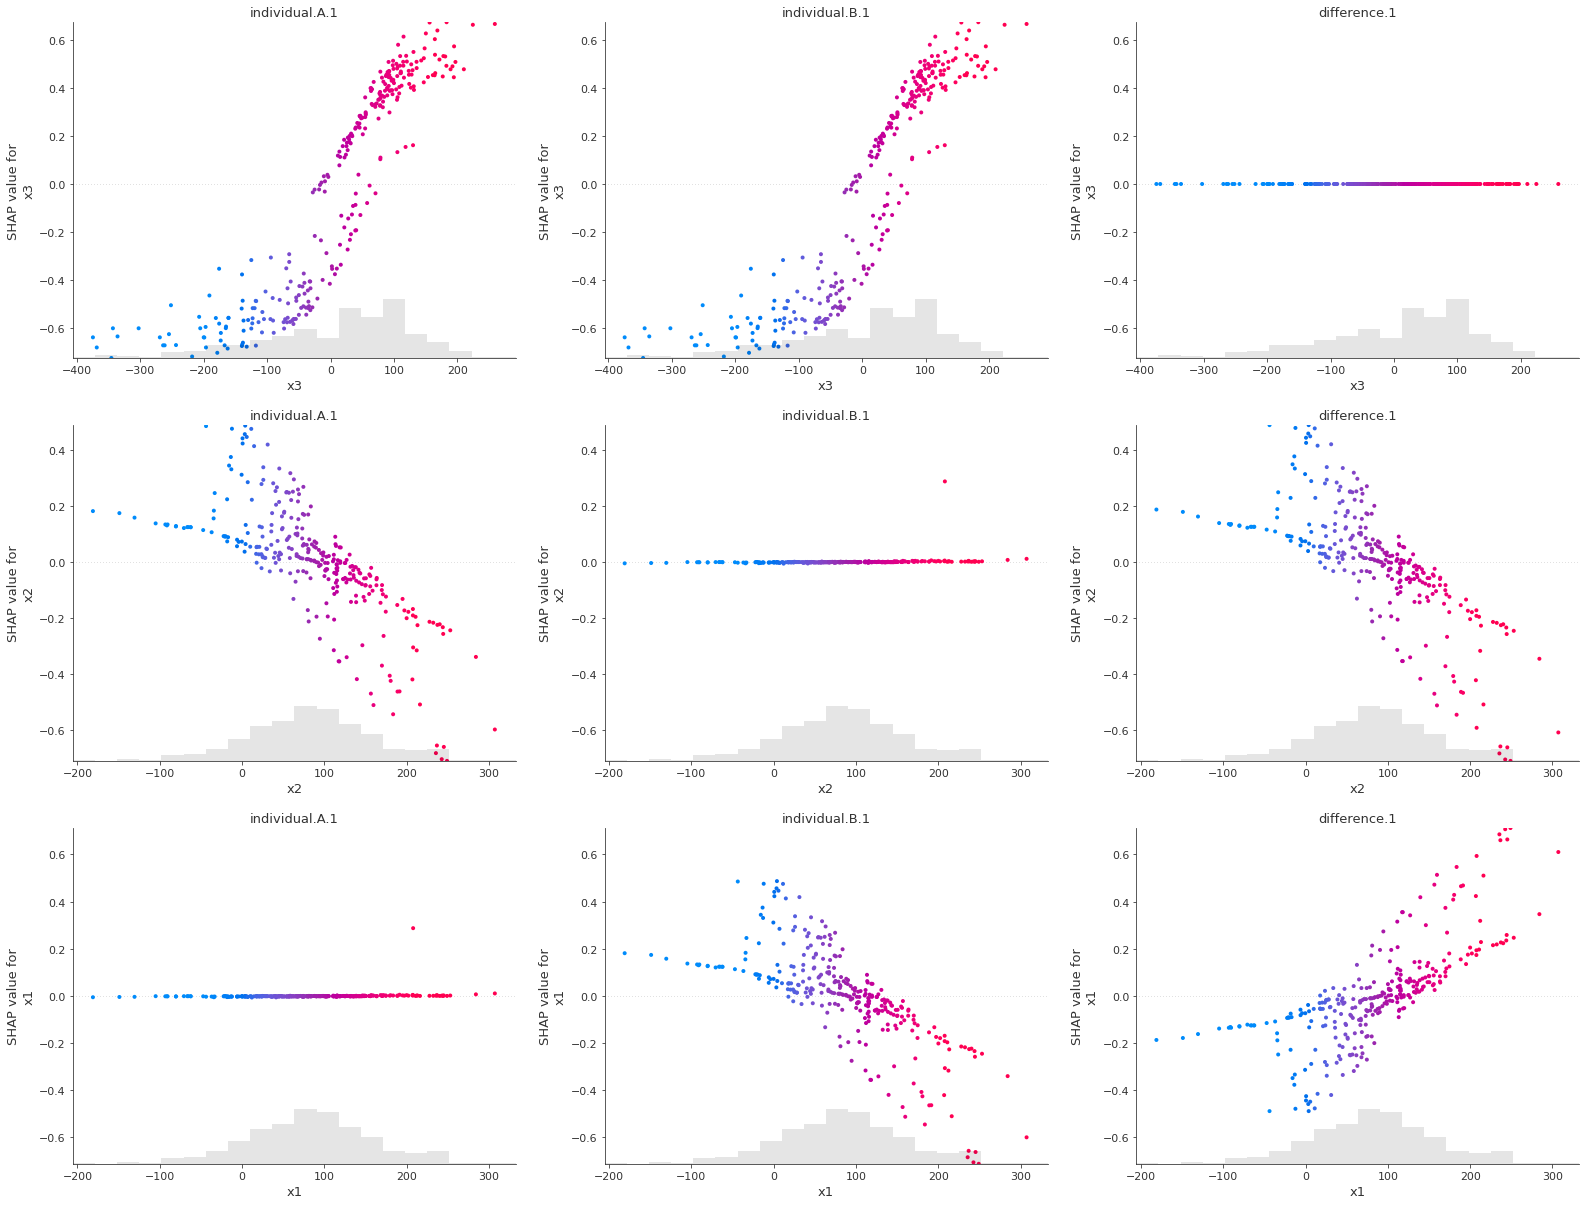

In [17]:
plot_feature_effects(merge_explanations(individual=explanations.indiv.labels[:, feature_order, 1],
                                        difference=explanations.indiv_diff.labels[:, feature_order, 1]),
                     color=is_pred_diff)

## Difference classifier explanations

### Feature importance

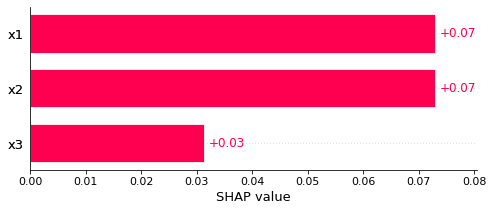

In [18]:
feature_order, feature_importance = calc_feature_order(explanations.mclass_diff.labels[:, :, comparer.difference_class_names])
plot_feature_importance_bar(feature_importance)

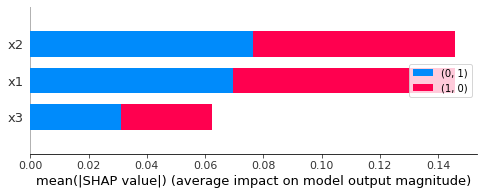

In [19]:
plot_feature_importance_bar(explanations.mclass_diff.labels[:, :, comparer.difference_class_names])

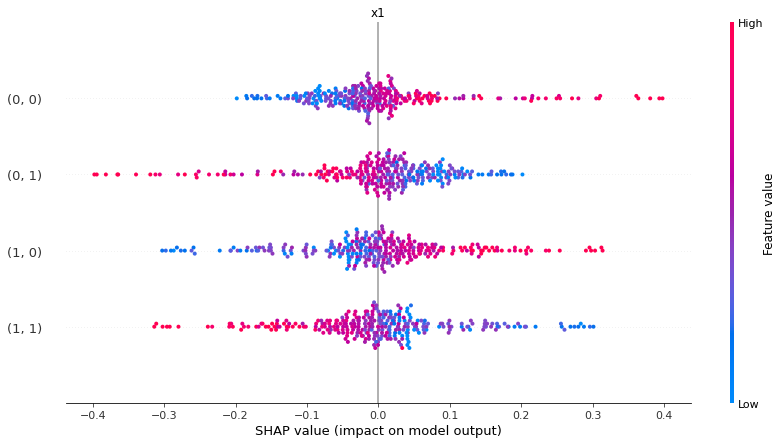

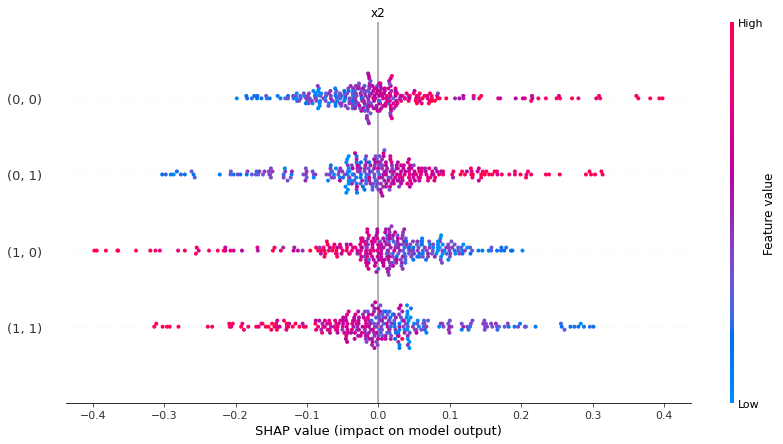

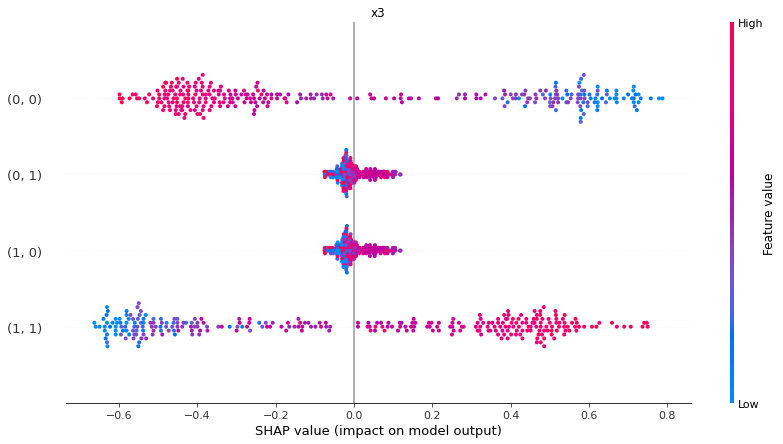

In [20]:
plot_feature_importance_scatter(explanations.mclass_diff.labels[:, feature_order])

### Feature effects

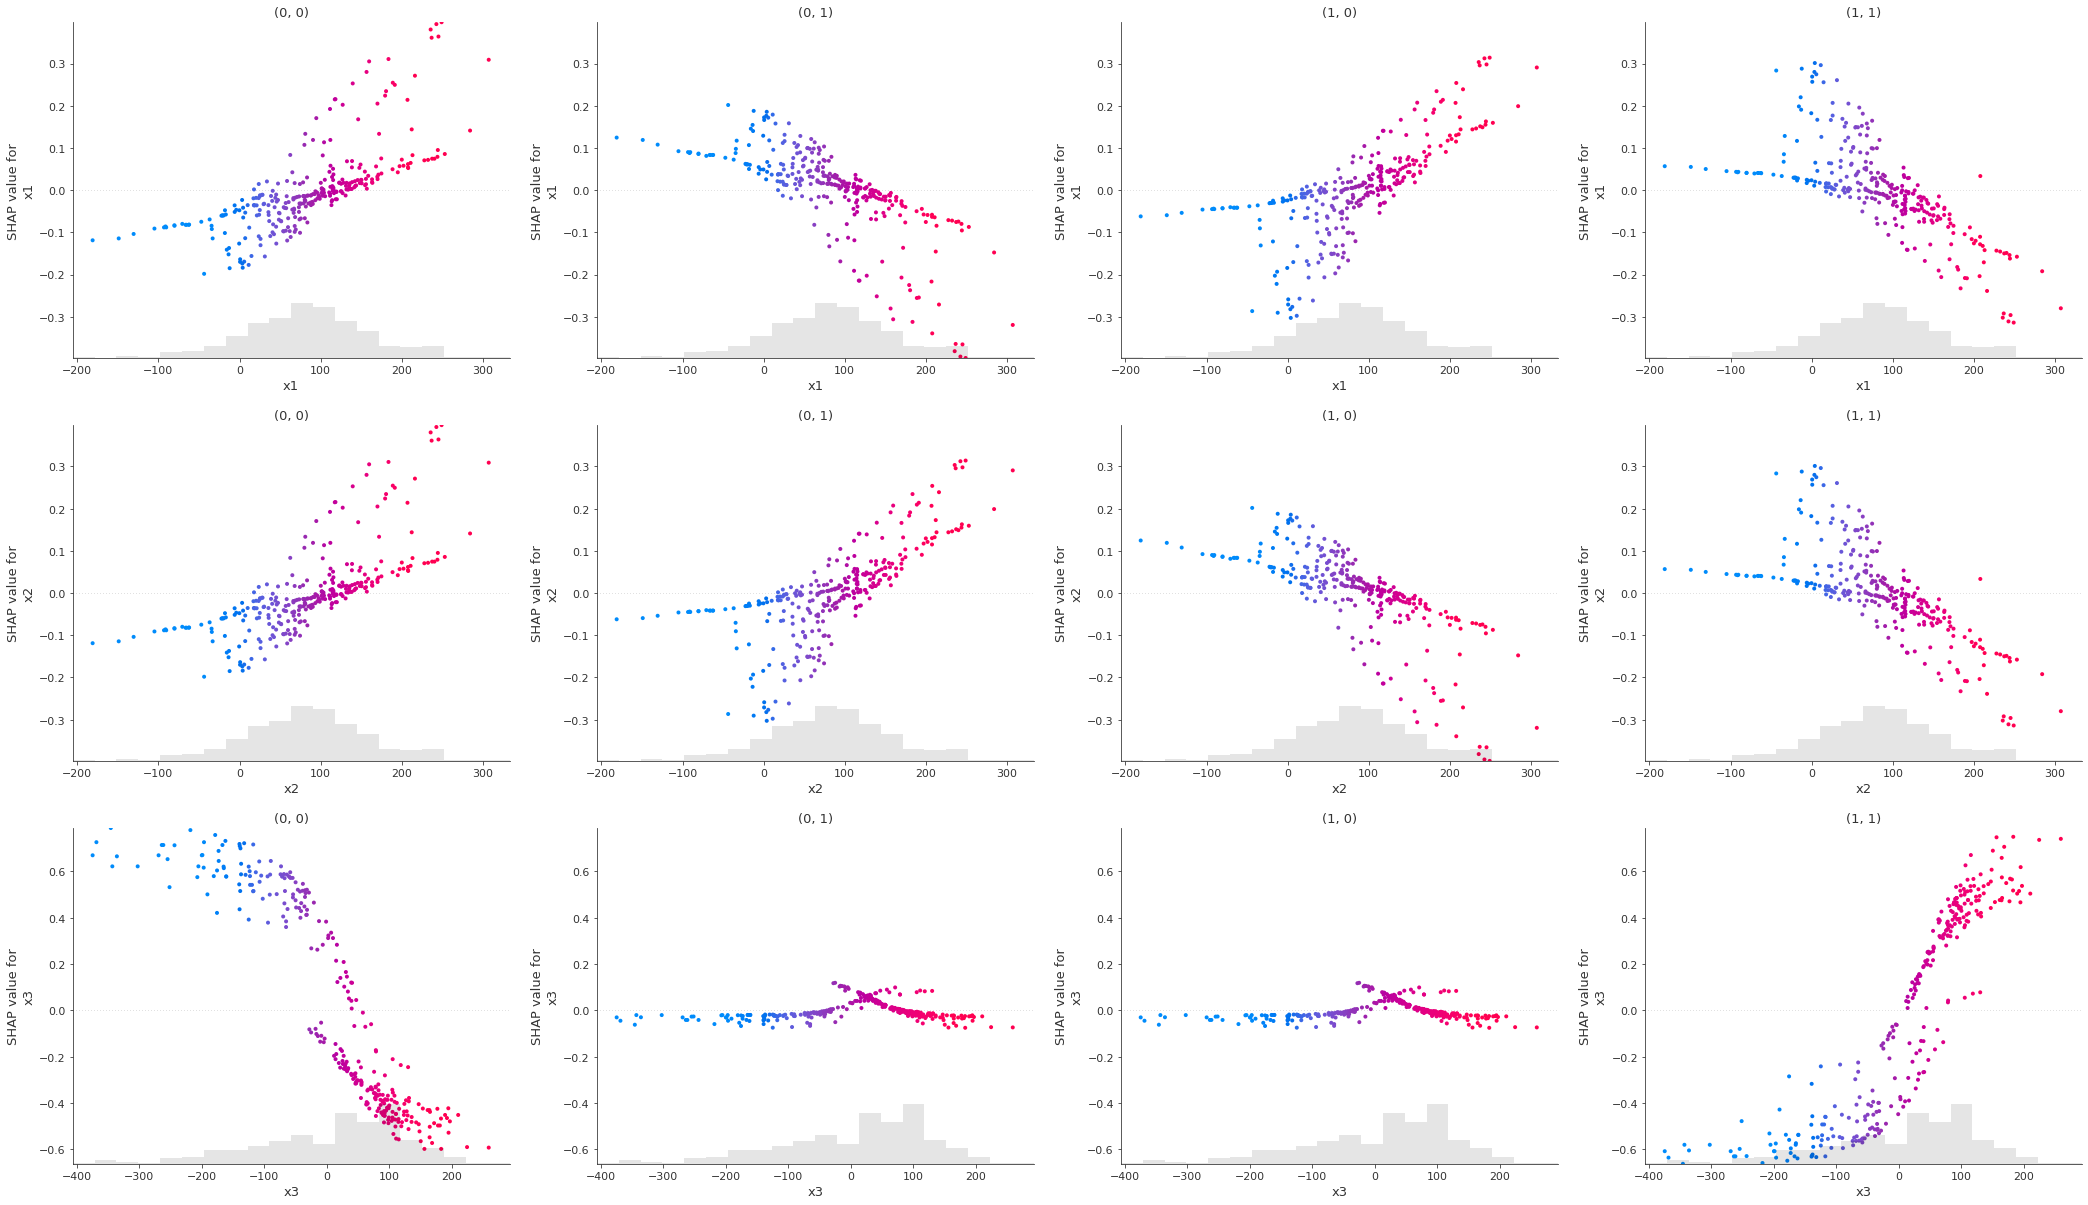

In [21]:
plot_feature_effects(explanations.mclass_diff.labels, color=is_pred_diff)